# Gaussian Process Regression (with GPytorch)
A Gaussian Process (GP) is a stochastic process commonly used in Bayesian non-parametrics, whose random variables follow a multivariate Gaussian distribution.  GPs are fully defined by a mean and covariance function:

$$f \sim \mathcal{GP}\left(\mu(x), \mathbf{K}_f(x, x')\right)$$

where  $x, x' \in\mathbf{X}$ are two data points (e.g. train and test), $\mu$ is the mean function (usually taken to be zero or constant), and $\mathbf{K}_f$ is the kernel function, which computes a covariance given two datapoints.

The aim is then to fit a posterior over *functions*.  GPs allow us to learn a distribution over functions given our observed data and predict unseen data with well-calibrated uncertainty, and is commonly used in Bayesian Optimization to maximize an objective. For a thorough introduction to Gaussian processes, please see [1]

With a PPL such as Bean Machine, we can be Bayesian about the parameters we care about, i.e. learn posterior distributions over these parameters rather than a point estimate.

In [1]:
import math
import copy
from functools import partial

import torch
import torch.distributions as dist

import beanmachine
import beanmachine.ppl as bm
from beanmachine.ppl.inference.single_site_no_u_turn_sampler import SingleSiteNoUTurnSampler
import beanmachine.ppl.experimental.gp as bgp
from beanmachine.ppl.experimental.gp.models import SimpleGP
from beanmachine.ppl.experimental.gp import likelihoods

import gpytorch as gpt
from gpytorch.kernels import Kernel
from gpytorch.distributions import MultivariateNormal

import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(123)
print('pytorch: ', torch.__version__)
print('gpytorch: ', gpt.__version__)
print('beanmachine: ', beanmachine.__version__)

pytorch:  1.7.0.dev20200901
gpytorch:  1.2.0
beanmachine:  0.0.1a1


In [2]:
x_train = torch.linspace(0, 1, 11)
y_train = torch.sin(x_train * (2 * math.pi)) + torch.randn(x_train.shape) * 0.2
x_test = torch.linspace(0, 1, 51).unsqueeze(-1)

We will use Bean Machine's custom kernel and likelihood primitives to define our GP as a module. `SimpleGP` is a simple wrapper around `gpytorch.models.ExactGP` that lifts learnable parameters to BM random variables.  The `forward()` method defines our GP Multivariate Normal prior, similar to a Gpytorch model.

In [3]:
class Regression(SimpleGP):
    def __init__(self,
                 x_train,
                 y_train,
                 mean,
                 kernel,
                 likelihood,
                 *args,
                 **kwargs):
        super().__init__(x_train, y_train, mean, kernel, likelihood)

    def forward(self, data, batch_shape=()):
        shape = data.shape[len(batch_shape)]
        jitter = torch.eye(shape, shape) * 1e-5
        for _ in range(len(batch_shape)):
            jitter = jitter.unsqueeze(0)
        if self.training:
            mean = self.mean(batch_shape).expand(data.shape[len(batch_shape):])
        else:
            mean = self.mean.expand(data.shape[:-1]) # overridden for evaluation
        cov = self.kernel(data) + jitter
        return MultivariateNormal(mean, cov)

Next, lets declare priors over our kernel parameters, mean, and observation noise. We'll use a periodic kernel with a learnable scale factor.

In [4]:
@bm.random_variable
def outputscale_prior():
    return dist.Uniform(torch.tensor(1.), torch.tensor(2.))

@bm.random_variable
def lengthscale_prior():
    return dist.Uniform(torch.tensor([0.01]), torch.tensor([0.5]))

@bm.random_variable
def period_length_prior():
    return dist.Uniform(torch.tensor([0.05]), torch.tensor([2.5]))

@bm.random_variable
def noise_prior():
    return dist.Uniform(torch.tensor([0.05]), torch.tensor([0.3]))

@bm.random_variable
def mean_prior(batch_shape=()):
    batch_shape += (1,)
    a = -1 * torch.ones(batch_shape)
    b = torch.ones(batch_shape)
    return dist.Uniform(a, b)


We'll create kernel and likelihood objects from our priors, and pass them to our GP model...

In [5]:
kernel = bgp.kernels.ScaleKernel(
            base_kernel=bgp.kernels.PeriodicKernel(period_length_prior=period_length_prior,
                                                   lengthscale_prior=lengthscale_prior),
            outputscale_prior=outputscale_prior
        )
likelihood = likelihoods.GaussianLikelihood(noise_prior=noise_prior)

gp = Regression(x_train, y_train, mean_prior, kernel, likelihood)

...and then run inference as usual:

In [6]:
num_samples = 100

gp_prior = partial(gp.__call__, x_train)
obs = {gp.likelihood(gp_prior): y_train}

nuts = SingleSiteNoUTurnSampler()
samples = nuts.infer([mean_prior(), lengthscale_prior(), period_length_prior(),
                      outputscale_prior()],
                     obs,
                     num_samples=num_samples,
                     num_adaptive_samples=10,
                     num_chains=1)

Let's take a look at how our model fit. We will plot the samples of our posterior as well as the predictives generated from our GP.

In [7]:
lengthscale_samples = samples.get_chain(0)[lengthscale_prior()]
outputscale_samples = samples.get_chain(0)[outputscale_prior()]
period_length_samples = samples.get_chain(0)[period_length_prior()]
mean_samples = samples.get_chain(0)[mean_prior()]

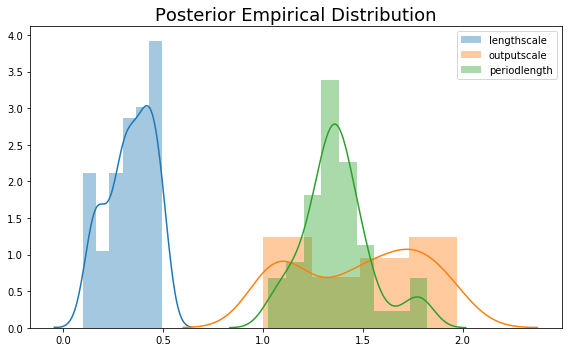

In [8]:
plt.figure(figsize=(8, 5))
sns.distplot(lengthscale_samples, label='lengthscale')
sns.distplot(outputscale_samples, label='outputscale')
sns.distplot(period_length_samples[:int(num_samples/2)], label='periodlength')
plt.legend()
plt.title("Posterior Empirical Distribution", fontsize=18)
plt.tight_layout()
plt.show()


To generate predictions, we will convert our model to a Gpytorch model by running in `eval` mode. We load our posterior samples with a python dict, keyed on the parameter namespace and valued on the torch tensor of samples. Note the `unsqueeze`s to allow broadcasting of the data dimension to the right. 

In [9]:
gp.eval() # converts to Gpytorch model in eval mode
gp.bm_load_samples({'kernel.outputscale': outputscale_samples,
               'kernel.base_kernel.lengthscale': lengthscale_samples.unsqueeze(-1),
               'kernel.base_kernel.period_length': period_length_samples.unsqueeze(-1),
               'mean': mean_samples,
              })
expanded_x_test = x_test.unsqueeze(0).repeat(num_samples, 1, 1)
output = gp(expanded_x_test.detach(), batch_shape=(num_samples,))

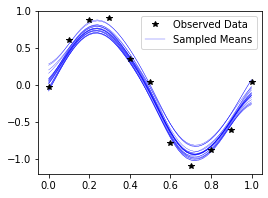

In [10]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*', zorder=10)
    for i in range(min(20, num_samples)):
        ax.plot(x_test.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)
    ax.legend(['Observed Data', 'Sampled Means'])

## References
[1] Rasmussen, Carl and Williams, Christopher. **Gaussian Processes for Machine Learning**. 2006.